# Comparison of the baltic region temperatures during Medival Warming Period (MWP), Little Ice Age (LIA) and Holocene Climate Optimum (HCO)

## First steps:

At first some python libraries are imported:

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

The model data is imported as a dataset:

In [2]:
temp = xr.open_dataset("/students_files/data/slo0043_echam6_code167_mm_1001_8850.ncslo0043_echam6_code167_mm_1001_8850.nc")

The longitude and latitude coordinates are adjusted and the dataset is shown:

In [3]:
# adjust values of lon and lat and show dataset

def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""
    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))
    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds
temp = adjust_lon_lat(temp, lon_name="lon", lat_name="lat", reverse=True)

print(temp)

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 192, time: 94200)
Coordinates:
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * time     (time) float64 1.001e+07 1.001e+07 1.001e+07 ... 8.85e+07 8.85e+07
  * lon      (lon) float64 -178.1 -176.2 -174.4 -172.5 ... 176.2 178.1 180.0
Data variables:
    var167   (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu May 09 17:04:11 2019: cdo -f nc -g t63grid copy slo0043...
    institution:  Max-Planck-Institute for Meteorology
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...


## Baltic region mean temperature:

Creating a Baltic Sea drainage basin boolean mask:

In [4]:
corner_points = [
    (18.0, 49),
    (23.0, 49),
    (28.0, 55.0),
    (32.0, 56.0),
    (35.0, 62.0),
    (30.0, 62.0),
    (29.0, 67.0),
    (19.0, 68.0),
    (12.0, 61.0),
    (12.0, 57.5),
    (8.0, 56.5),
    (10.0, 53.0),
    (13.5, 52.5)
]

polygon = Polygon(corner_points)

lat_mask = (temp['lat'] >= polygon.bounds[1]) & (temp['lat'] <= polygon.bounds[3])
lon_mask = (temp['lon'] >= polygon.bounds[0]) & (temp['lon'] <= polygon.bounds[2])
mask = (lat_mask & lon_mask)

lat_values = temp['lat'].values
lon_values = temp['lon'].values
for i in range(len(lat_values)):
    for j in range(len(lon_values)):
        if not polygon.contains(Point(lon_values[j], lat_values[i])):
            mask[i, j] = False

# use the boolean mask to select the data
# baltic_data = temp.where(mask)

The baltic region outline is prepared:

In [5]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def subplot_cartopy_nice_baltic(ax):    
    """
    Adjust cartopy plots for the Baltic Sea
    """
    ax.set_aspect("auto")
    ax.coastlines("10m")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.0, linestyle='-')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(list(np.arange(-90, 60, 10)))
    gl.ylocator = mticker.FixedLocator(list(np.arange(-60, 80, 5)))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.spines['geo'].set_linewidth(5)
    ax.spines['geo'].set_edgecolor('black')
    ax.set_aspect('auto')

Plot of the mask:

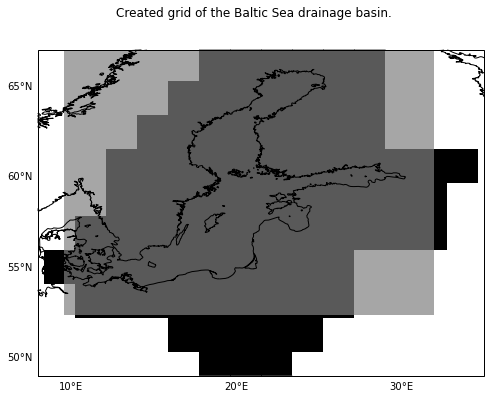

In [6]:
temp['lon'] = np.reshape(temp['lon'], (-1,))
temp['lat'] = np.reshape(temp['lat'], (-1,))

x, y = np.meshgrid(temp['lon'], temp['lat'])

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
im = plt.pcolormesh(x, y, mask, cmap='gray_r', shading='auto', transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection
im = plt.axvspan(9.6, 32, ymin=0.185, ymax=1, facecolor='grey', alpha=0.7)

subplot_cartopy_nice_baltic(ax)
ax.spines['geo'].set_linewidth(1)

# add axis labels and a title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(8, 35)
plt.ylim(49, 67,4)
plt.suptitle('Created grid of the Baltic Sea drainage basin.');
# plt.figtext(0, -0.1, 'The mask uses 12 corner points (see code above for coordinates). The deviation from \n common drainage basin maps is a result of different coordinate systems being used.');

The temperature values are averaged for the baltic region and converted to °C:

In [7]:
temp_baltic = temp.where(mask)
temp_baltic = temp_baltic.sel(lat=slice(49, 68), lon=slice(8, 35))
mean_temp_baltic = temp_baltic.mean(dim=['lat', 'lon'])
mean_temp_baltic -= 273.15

The following cell calculates and plots the baltic region annual mean temperature:

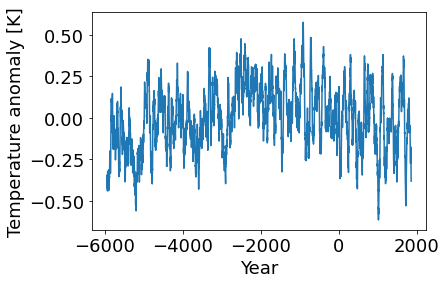

In [32]:
rolling_mean = mean_temp_baltic.rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_mean = rolling_mean.rolling(time=50).mean()
rolling_mean['time'] = xr.DataArray(range(-6000, rolling_mean.time.size-6000), dims='time')
temp = rolling_mean['var167'] - rolling_mean['var167'].mean(dim=['time'])

plt.plot(rolling_mean['time'], temp)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Temperature anomaly [K]', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
#plt.suptitle('Baltic annual mean temperature 200y MA', fontweight='bold')
plt.savefig("/students_files/marti/plots/res_09_show_hcomcalia", bbox_inches='tight')
plt.show();

Now we take a look at the temperature during specific periods which we try to connect with the HCO, MCA, LIA:

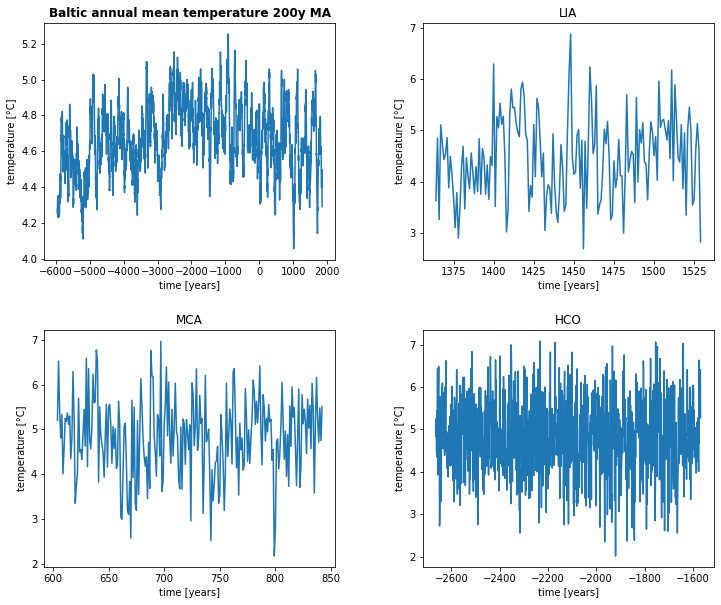

In [9]:
# Calculating the annual temperature and adapting time scale -6000 to 1850, determining rolling mean legnth
rolling_mean = mean_temp_baltic['var167'].rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_mean['time'] = xr.DataArray(range(-6000, rolling_mean.time.size-6000), dims='time')
temp_annual = rolling_mean.rolling(time=50).mean()

# Determining the moving average length and creating MCA data
temp_lia = rolling_mean.isel(time=slice(1364 +6000, 1530 +6000))
temp_lia = temp_lia.rolling(time=1).mean()
temp_lia['time'] = xr.DataArray(range(1364,1530), dims='time')

# Determining the moving average length and creating LIA data
temp_mca = rolling_mean.isel(time=slice(604 +6000, 843 +6000))
temp_mca = temp_mca.rolling(time=1).mean()
temp_mca['time'] = xr.DataArray(range(604,843), dims='time')

# Determining the moving average length and creating HCO data
temp_hco = rolling_mean.isel(time=slice(-2664 +6000,-1567 +6000))
temp_hco = temp_hco.rolling(time=1).mean()
temp_hco['time'] = xr.DataArray(range(-2664,-1567), dims='time')


# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].plot(temp_annual['time'], temp_annual)
axs[0,0].set_title('Baltic annual mean temperature 200y MA', fontweight='bold')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('temperature [°C]')

im2 = axs[0,1].plot(temp_lia['time'], temp_lia)
axs[0,1].set_title('LIA')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('temperature [°C]')

im3 = axs[1,0].plot(temp_mca['time'], temp_mca)
axs[1,0].set_title('MCA')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('temperature [°C]')

im4 = axs[1,1].plot(temp_hco['time'], temp_hco)
axs[1,1].set_title('HCO')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('temperature [°C]');

# fig.suptitle('Seasonal mean temperatures in the baltic region, 200y MA', fontsize=16, fontweight='bold');

After determining the periods we want to investigate further, we are now looking at the mean temperatures over the periods:

In [10]:
rolling_mean = temp_baltic['var167'].rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_mean['time'] = xr.DataArray(range(-6000, rolling_mean.time.size-6000), dims='time')
mean_total = rolling_mean.mean(dim=['time'])
mean_total -= 273.15

# Calculating HCO mean T heatmap
mean_hco = rolling_mean.isel(time=slice(6000 - 2664, 6000 - 1567)).mean(dim=['time'])
mean_hco -= 273.15
mean_hco = mean_hco - mean_total

# Calculating MCA mean T heatmap
mean_mca = rolling_mean.isel(time=slice(6000 + 604, 6000 + 843)).mean(dim=['time'])
mean_mca -= 273.15
mean_mca = mean_mca - mean_total

# Calculating LIA1 mean T heatmap
mean_lia1 = rolling_mean.isel(time=slice(6000 + 1130, 6000 + 1280)).mean(dim=['time'])
mean_lia1 -= 273.15
mean_lia1 = mean_lia1 - mean_total

# Calculating LIA2 mean T heatmap
mean_lia2 = rolling_mean.isel(time=slice(6000 + 1364, 6000 + 1530)).mean(dim=['time'])
mean_lia2 -= 273.15
mean_lia2 = mean_lia2 - mean_total

print(mean_hco.mean(dim=['lat','lon']))
print(mean_mca.mean(dim=['lat','lon']))
print(mean_lia1.mean(dim=['lat','lon']))
print(mean_lia2.mean(dim=['lat','lon']))
print(mean_total.mean(dim=['lat','lon']))

<xarray.DataArray ()>
array(0.16983989, dtype=float32)
<xarray.DataArray ()>
array(0.16237226, dtype=float32)
<xarray.DataArray ()>
array(-0.21639316, dtype=float32)
<xarray.DataArray ()>
array(-0.19617434, dtype=float32)
<xarray.DataArray ()>
array(4.6729426, dtype=float32)


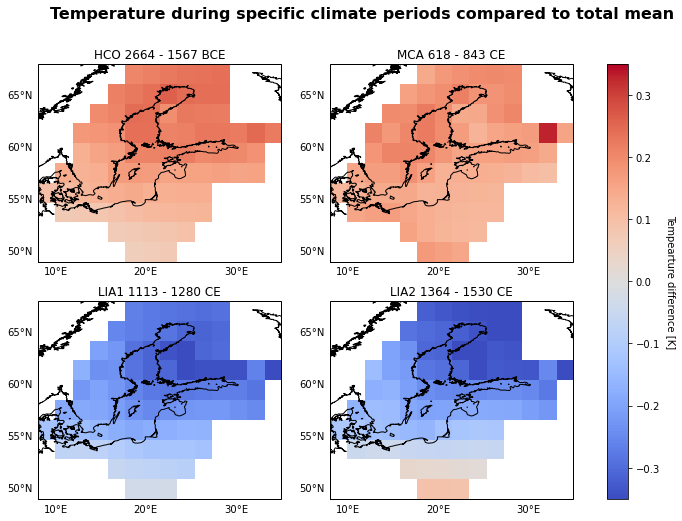

In [11]:
# colorbar range
vmin = -0.35
vmax = 0.35

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    mean_hco,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('HCO 2664 - 1567 BCE')

im2 = axs[0,1].imshow(
    mean_mca, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('MCA 618 - 843 CE')

im3 = axs[1,0].imshow(
    mean_lia1, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('LIA1 1113 - 1280 CE')

im4 = axs[1,1].imshow(
    mean_lia2,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('LIA2 1364 - 1530 CE')

fig.suptitle('Temperature during specific climate periods compared to total mean', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Tempearture difference [K]', rotation=270, labelpad=15)
plt.show()

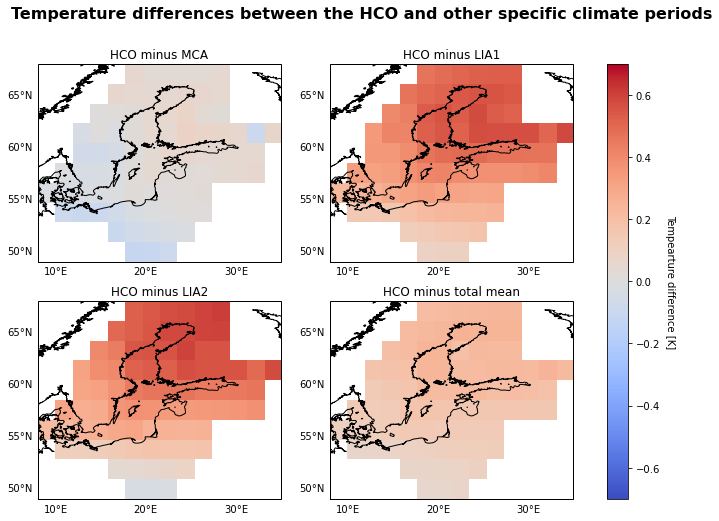

In [26]:
# HCO compared to MCA; LIA1, LIA2, total AVG
hco_mca = mean_hco - mean_mca
hco_lia1 = mean_hco - mean_lia1
hco_lia2 = mean_hco - mean_lia2
hco_total = mean_hco

# colorbar range
vmin = -0.7
vmax = 0.7

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    hco_mca,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('HCO minus MCA')

im2 = axs[0,1].imshow(
    hco_lia1, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('HCO minus LIA1')

im3 = axs[1,0].imshow(
    hco_lia2, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('HCO minus LIA2')

im4 = axs[1,1].imshow(
    hco_total,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('HCO minus total mean')

fig.suptitle('Temperature differences between the HCO and other specific climate periods', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Tempearture difference [K]', rotation=270, labelpad=15)
plt.show()

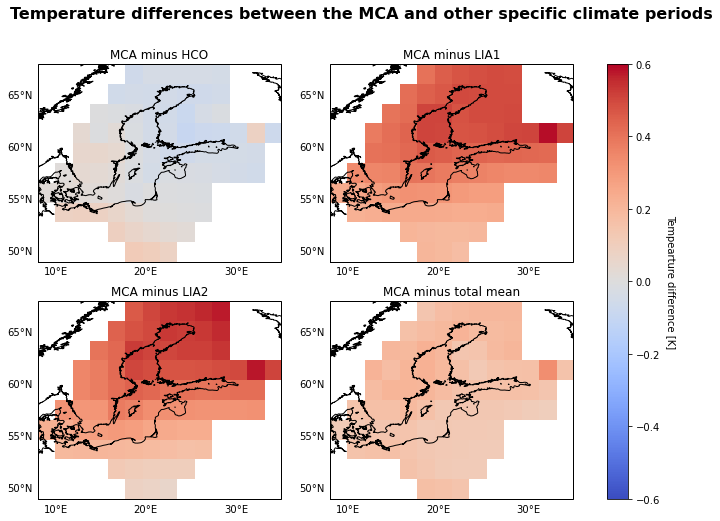

In [27]:
# MCA compared to HCO, LIA1, LIA2, total AVG
mca_hco = mean_mca - mean_hco
mca_lia1 = mean_mca - mean_lia1
mca_lia2 = mean_mca - mean_lia2
mca_total = mean_mca

# colorbar range
vmin = -0.6
vmax = 0.6

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    mca_hco,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('MCA minus HCO')

im2 = axs[0,1].imshow(
    mca_lia1, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('MCA minus LIA1')

im3 = axs[1,0].imshow(
    mca_lia2, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('MCA minus LIA2')

im4 = axs[1,1].imshow(
    mca_total,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('MCA minus total mean')

fig.suptitle('Temperature differences between the MCA and other specific climate periods', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Tempearture difference [K]', rotation=270, labelpad=15)
plt.show()

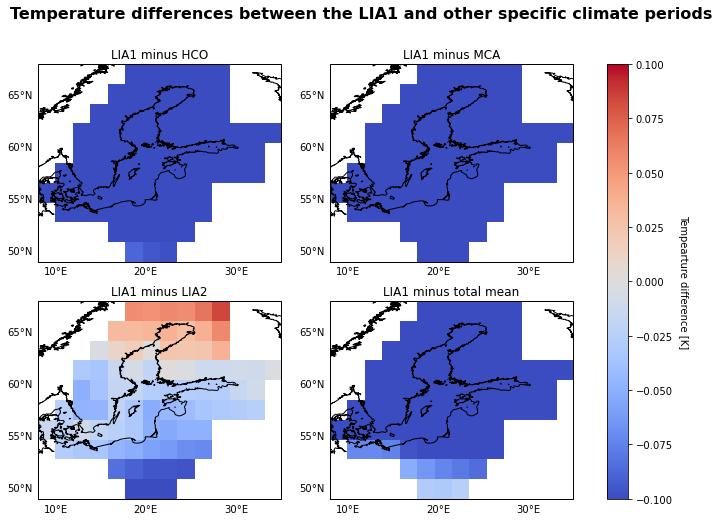

In [14]:
# LIA1 compared to HCO, MCA, LIA2, total AVG
lia1_hco = mean_lia1 - mean_hco
lia1_mca = mean_lia1 - mean_mca
lia1_lia2 = mean_lia1 - mean_lia2
lia1_total = mean_lia1

# colorbar range
vmin = -0.1
vmax = 0.1

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    lia1_hco,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('LIA1 minus HCO')

im2 = axs[0,1].imshow(
    lia1_mca, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('LIA1 minus MCA')

im3 = axs[1,0].imshow(
    lia1_lia2, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('LIA1 minus LIA2')

im4 = axs[1,1].imshow(
    lia1_total,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('LIA1 minus total mean')

fig.suptitle('Temperature differences between the LIA1 and other specific climate periods', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Tempearture difference [K]', rotation=270, labelpad=15)
plt.show()

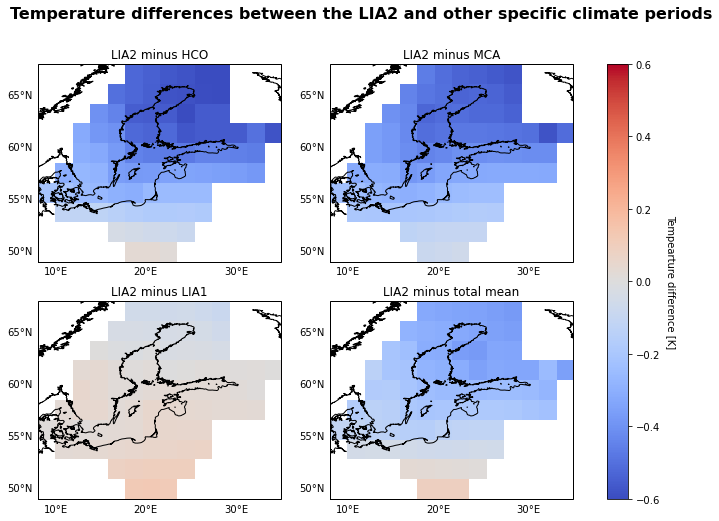

In [28]:
# LIA2 compared to HCO, MCA, LIA2, total AVG
lia2_hco = mean_lia2 - mean_hco
lia2_mca = mean_lia2 - mean_mca
lia2_lia1 = mean_lia2 - mean_lia1
lia2_total = mean_lia2

# colorbar range
vmin = -0.6
vmax = 0.6

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    lia2_hco,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('LIA2 minus HCO')

im2 = axs[0,1].imshow(
    lia2_mca, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('LIA2 minus MCA')

im3 = axs[1,0].imshow(
    lia2_lia1, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('LIA2 minus LIA1')

im4 = axs[1,1].imshow(
    lia2_total,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('LIA2 minus total mean')

fig.suptitle('Temperature differences between the LIA2 and other specific climate periods', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Tempearture difference [K]', rotation=270, labelpad=15)
plt.show()

In [16]:
# Zusammenfassung

# - hco um 0,17K wärmer und mca um 0,15K wärmer als durchschnitt
# - zwei potentielle lia-zeiträume die je um 0,22K bzw 0,20K kälter waren als durchschnitt
# - in genannten Perioden sind die T-Unterschiede umso stärker je weiter nördlich, bis zu 0,3K wärmer und 0,35K kälter
# - hco im südwesten um 0,1K kälter und im nordosten um 0,1K wärmer als mca (dazwischen kontinuierlicher übergang)
# - beide lia im norden bis zu 0,6K kälter als hco und mca, im süden höchstens 0,2K
# - lia1 im norden 0,1K wärmer und im süden 0,1K kälter als lia2

# Seasonal comparison of the climate periods:

At first we calculate the seasonal temperature development averaged over the whole Baltic region for each season:

In [17]:
rolling_data = mean_temp_baltic.isel(time=slice(2, None))
rolling_data = rolling_data['var167'].rolling(time=3, center=False, min_periods=3).mean()
rolling_data = rolling_data[2::3]
seasonal_mean_temp_baltic = xr.Dataset({"var167": ("time", rolling_data)}, coords={"time": rolling_data.coords["time"]})


# Creating spring_mean_temp_baltic DataArray and applying 200y MA
spring_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][0::4]
spring_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(spring_mean_temp_baltic))
spring_mean_temp_baltic = spring_mean_temp_baltic.rolling(time=200).mean()

# Creating summer_mean_temp_baltic DataArray and applying 200y MA
summer_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][1::4]
summer_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(summer_mean_temp_baltic))
summer_mean_temp_baltic = summer_mean_temp_baltic.rolling(time=200).mean()

# Creating fall_mean_temp_baltic DataArray and applying 200y MA
fall_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][2::4]
fall_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(fall_mean_temp_baltic))
fall_mean_temp_baltic = fall_mean_temp_baltic.rolling(time=200).mean()

# Creating winter_mean_temp_baltic DataArray and applying 200y MA
winter_mean_temp_baltic = seasonal_mean_temp_baltic['var167'][3::4]
winter_mean_temp_baltic.coords['time'] = range(-6000, -6000+len(winter_mean_temp_baltic))
winter_mean_temp_baltic = winter_mean_temp_baltic.rolling(time=200).mean()

Now we can choose particular periods out of the whole dataset:

In [18]:
# Picking the HCO period
hco_spring_temp = spring_mean_temp_baltic.isel(time=slice(-2664 +6000,-1567 +6000))
hco_spring_temp.coords['time'] = range(-2664, -2664+len(hco_spring_temp))
hco_summer_temp = summer_mean_temp_baltic.isel(time=slice(-2664 +6000,-1567 +6000))
hco_summer_temp.coords['time'] = range(-2664, -2664+len(hco_summer_temp))
hco_fall_temp = fall_mean_temp_baltic.isel(time=slice(-2664 +6000,-1567 +6000))
hco_fall_temp.coords['time'] = range(-2664, -2664+len(hco_fall_temp))
hco_winter_temp = winter_mean_temp_baltic.isel(time=slice(-2664 +6000,-1567 +6000))
hco_winter_temp.coords['time'] = range(-2664, -2664+len(hco_winter_temp))

# Picking the MCA period
mca_spring_temp = spring_mean_temp_baltic.isel(time=slice(604 +6000,843 +6000))
mca_spring_temp.coords['time'] = range(604, 604+len(mca_spring_temp))
mca_summer_temp = summer_mean_temp_baltic.isel(time=slice(604 +6000,843 +6000))
mca_summer_temp.coords['time'] = range(604, 604+len(mca_summer_temp))
mca_fall_temp = fall_mean_temp_baltic.isel(time=slice(604 +6000,843 +6000))
mca_fall_temp.coords['time'] = range(604, 604+len(mca_fall_temp))
mca_winter_temp = winter_mean_temp_baltic.isel(time=slice(604 +6000,843 +6000))
mca_winter_temp.coords['time'] = range(604, 604+len(mca_winter_temp))

# Picking the LIA1 period
lia1_spring_temp = spring_mean_temp_baltic.isel(time=slice(1130 +6000,1280 +6000))
lia1_spring_temp.coords['time'] = range(1130, 1130+len(lia1_spring_temp))
lia1_summer_temp = summer_mean_temp_baltic.isel(time=slice(1130 +6000,1280 +6000))
lia1_summer_temp.coords['time'] = range(1130, 1130+len(lia1_summer_temp))
lia1_fall_temp = fall_mean_temp_baltic.isel(time=slice(1130 +6000,1280 +6000))
lia1_fall_temp.coords['time'] = range(1130, 1130+len(lia1_fall_temp))
lia1_winter_temp = winter_mean_temp_baltic.isel(time=slice(1130 +6000,1280 +6000))
lia1_winter_temp.coords['time'] = range(1130, 1130+len(lia1_winter_temp))

# Picking the LIA2 period
lia2_spring_temp = spring_mean_temp_baltic.isel(time=slice(1364 +6000,1530 +6000))
lia2_spring_temp.coords['time'] = range(1364, 1364+len(lia2_spring_temp))
lia2_summer_temp = summer_mean_temp_baltic.isel(time=slice(1364 +6000,1530 +6000))
lia2_summer_temp.coords['time'] = range(1364, 1364+len(lia2_summer_temp))
lia2_fall_temp = fall_mean_temp_baltic.isel(time=slice(1364 +6000,1530 +6000))
lia2_fall_temp.coords['time'] = range(1364, 1364+len(lia2_fall_temp))
lia2_winter_temp = winter_mean_temp_baltic.isel(time=slice(1364 +6000,1530 +6000))
lia2_winter_temp.coords['time'] = range(1364, 1364+len(lia2_winter_temp))

The following cell creates the plots of the seasonal temperatures for all periods:

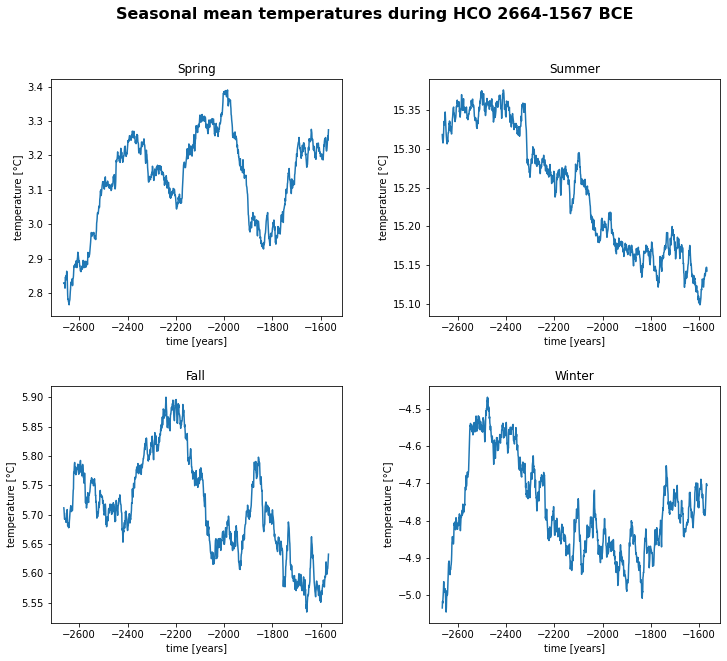

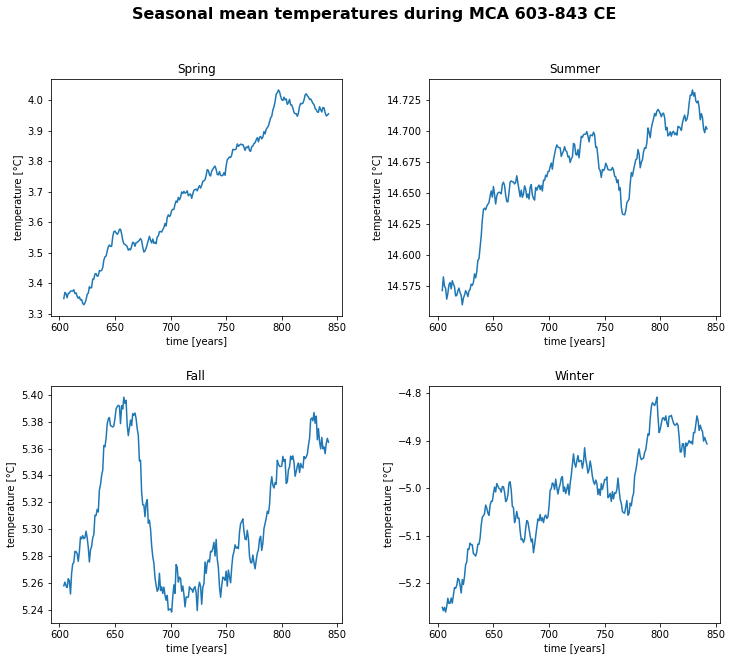

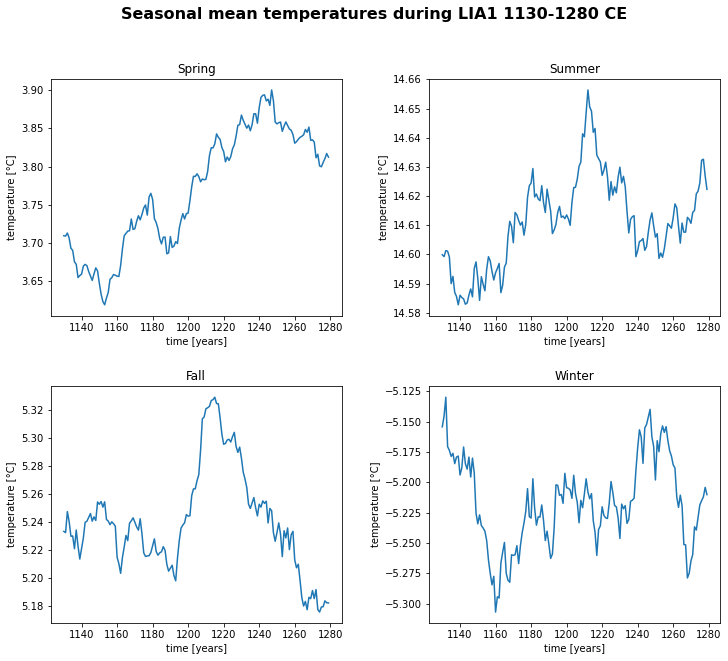

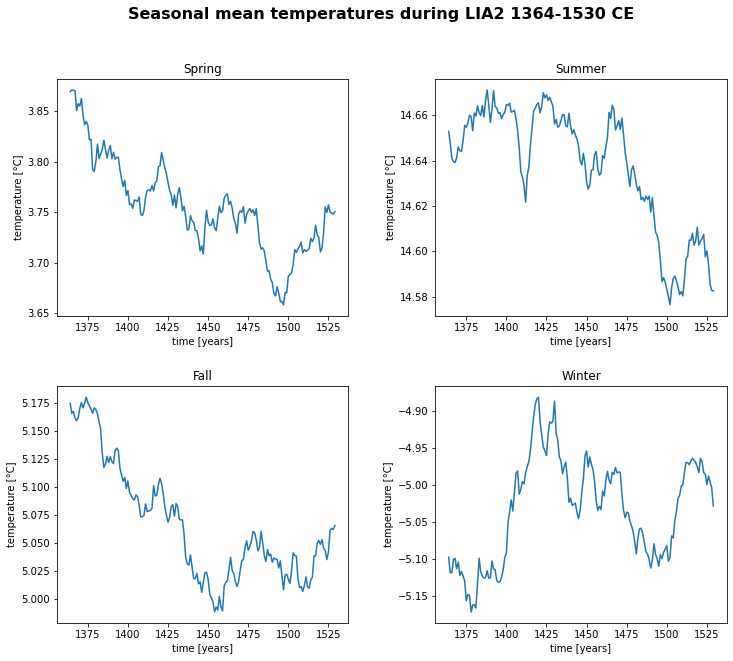

In [19]:
#hco

fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].plot(hco_spring_temp['time'], hco_spring_temp)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('temperature [°C]')

im2 = axs[0,1].plot(hco_summer_temp['time'], hco_summer_temp)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('temperature [°C]')

im3 = axs[1,0].plot(hco_fall_temp['time'], hco_fall_temp)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('temperature [°C]')

im4 = axs[1,1].plot(hco_winter_temp['time'], hco_winter_temp)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('temperature [°C]');

fig.suptitle('Seasonal mean temperatures during HCO 2664-1567 BCE', fontsize=16, fontweight='bold');

#########################################################################################
#mca 

fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].plot(mca_spring_temp['time'], mca_spring_temp)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('temperature [°C]')

im2 = axs[0,1].plot(mca_summer_temp['time'], mca_summer_temp)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('temperature [°C]')

im3 = axs[1,0].plot(mca_fall_temp['time'], mca_fall_temp)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('temperature [°C]')

im4 = axs[1,1].plot(mca_winter_temp['time'], mca_winter_temp)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('temperature [°C]');

fig.suptitle('Seasonal mean temperatures during MCA 603-843 CE', fontsize=16, fontweight='bold');

#######################################################################################
#lia1

fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].plot(lia1_spring_temp['time'], lia1_spring_temp)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('temperature [°C]')

im2 = axs[0,1].plot(lia1_summer_temp['time'], lia1_summer_temp)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('temperature [°C]')

im3 = axs[1,0].plot(lia1_fall_temp['time'], lia1_fall_temp)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('temperature [°C]')

im4 = axs[1,1].plot(lia1_winter_temp['time'], lia1_winter_temp)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('temperature [°C]');

fig.suptitle('Seasonal mean temperatures during LIA1 1130-1280 CE', fontsize=16, fontweight='bold');

#########################################################################################
#lia2

fig, axs = plt.subplots(2, 2, figsize=(12,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})

im1 = axs[0,0].plot(lia2_spring_temp['time'], lia2_spring_temp)
axs[0,0].set_title('Spring')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('temperature [°C]')

im2 = axs[0,1].plot(lia2_summer_temp['time'], lia2_summer_temp)
axs[0,1].set_title('Summer')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('temperature [°C]')

im3 = axs[1,0].plot(lia2_fall_temp['time'], lia2_fall_temp)
axs[1,0].set_title('Fall')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('temperature [°C]')

im4 = axs[1,1].plot(lia2_winter_temp['time'], lia2_winter_temp)
axs[1,1].set_title('Winter')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('temperature [°C]');

fig.suptitle('Seasonal mean temperatures during LIA2 1364-1530 CE', fontsize=16, fontweight='bold');

Now lets look at heatmaps once again. The next cell calculates the seasonal mean heatmaps over the climate periods:

In [20]:
rolling_data = temp_baltic.isel(time=slice(2, None))
seasonal_temp = rolling_data['var167'].rolling(time=3, center=False, min_periods=3).mean()
seasonal_temp = seasonal_temp[2::3]

# Selecting spring data from the rolling_mean dataset as a dataarray
spring_temp = seasonal_temp[0::4]
spring_temp.coords['time'] = range(-6000, -6000+len(spring_temp))
spring_temp -= 273.15
spring_mean = spring_temp.mean(dim=['time'])

# Selecting summer data from the rolling_mean dataset as a dataarray
summer_temp = seasonal_temp[1::4]
summer_temp.coords['time'] = range(-6000, -6000+len(summer_temp))
summer_temp -= 273.15
summer_mean = summer_temp.mean(dim=['time'])

# Selecting fall data from the rolling_mean dataset as a dataarray
fall_temp = seasonal_temp[2::4]
fall_temp.coords['time'] = range(-6000, -6000+len(fall_temp))
fall_temp -= 273.15
fall_mean = fall_temp.mean(dim=['time'])

# Selecting winter data from the rolling_mean dataset as a dataarray
winter_temp = seasonal_temp[3::4]
winter_temp.coords['time'] = range(-6000, -6000+len(winter_temp))
winter_temp -= 273.15
winter_mean = winter_temp.mean(dim=['time'])


hco_spring_mean = spring_temp.isel(time=slice(-2664 +6000,-1567 +6000))
hco_spring_mean = hco_spring_mean.mean(dim=['time']) - spring_mean
hco_summer_mean = summer_temp.isel(time=slice(-2664 +6000,-1567 +6000))
hco_summer_mean = hco_summer_mean.mean(dim=['time']) - summer_mean
hco_fall_mean = fall_temp.isel(time=slice(-2664 +6000,-1567 +6000))
hco_fall_mean = hco_fall_mean.mean(dim=['time']) - fall_mean
hco_winter_mean = winter_temp.isel(time=slice(-2664 +6000,-1567 +6000))
hco_winter_mean = hco_winter_mean.mean(dim=['time']) - winter_mean

mca_spring_mean = spring_temp.isel(time=slice(604 +6000,843 +6000))
mca_spring_mean = mca_spring_mean.mean(dim=['time']) - spring_mean
mca_summer_mean = summer_temp.isel(time=slice(604 +6000,843 +6000))
mca_summer_mean = mca_summer_mean.mean(dim=['time']) - summer_mean
mca_fall_mean = fall_temp.isel(time=slice(604 +6000,843 +6000))
mca_fall_mean = mca_fall_mean.mean(dim=['time']) - fall_mean
mca_winter_mean = winter_temp.isel(time=slice(604 +6000,843 +6000))
mca_winter_mean = mca_winter_mean.mean(dim=['time']) - winter_mean

lia1_spring_mean = spring_temp.isel(time=slice(1130 +6000,1280 +6000))
lia1_spring_mean = lia1_spring_mean.mean(dim=['time']) - spring_mean
lia1_summer_mean = summer_temp.isel(time=slice(1130 +6000,1280 +6000))
lia1_summer_mean = lia1_summer_mean.mean(dim=['time']) - summer_mean
lia1_fall_mean = fall_temp.isel(time=slice(1130 +6000,1280 +6000))
lia1_fall_mean = lia1_fall_mean.mean(dim=['time']) - fall_mean
lia1_winter_mean = winter_temp.isel(time=slice(1130 +6000,1280 +6000))
lia1_winter_mean = lia1_winter_mean.mean(dim=['time']) - winter_mean

lia2_spring_mean = spring_temp.isel(time=slice(1364 +6000,1530 +6000))
lia2_spring_mean = lia2_spring_mean.mean(dim=['time']) - spring_mean
lia2_summer_mean = summer_temp.isel(time=slice(1364 +6000,1530 +6000))
lia2_summer_mean = lia2_summer_mean.mean(dim=['time']) - summer_mean
lia2_fall_mean = fall_temp.isel(time=slice(1364 +6000,1530 +6000))
lia2_fall_mean = lia2_fall_mean.mean(dim=['time']) - fall_mean
lia2_winter_mean = winter_temp.isel(time=slice(1364 +6000,1530 +6000))
lia2_winter_mean = lia2_winter_mean.mean(dim=['time']) - winter_mean

Spring difference to mean plot:

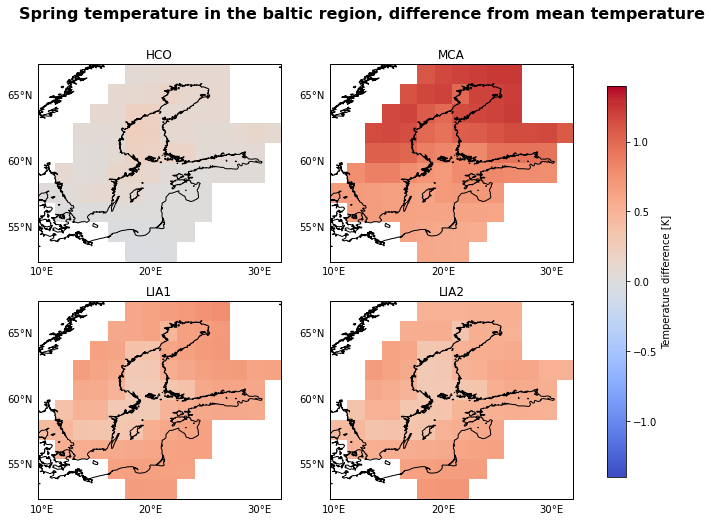

In [21]:
# colorbar range
vmin = -1.4
vmax = 1.4

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    hco_spring_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('HCO')

im2 = axs[0,1].imshow(
    mca_spring_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('MCA')

im3 = axs[1,0].imshow(
    lia1_spring_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('LIA1')

im4 = axs[1,1].imshow(
    lia2_spring_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('LIA2')

fig.suptitle('Spring temperature in the baltic region, difference from mean temperature', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, shrink=0.9, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Temperature difference [K]');

Sumer difference to mean plot:

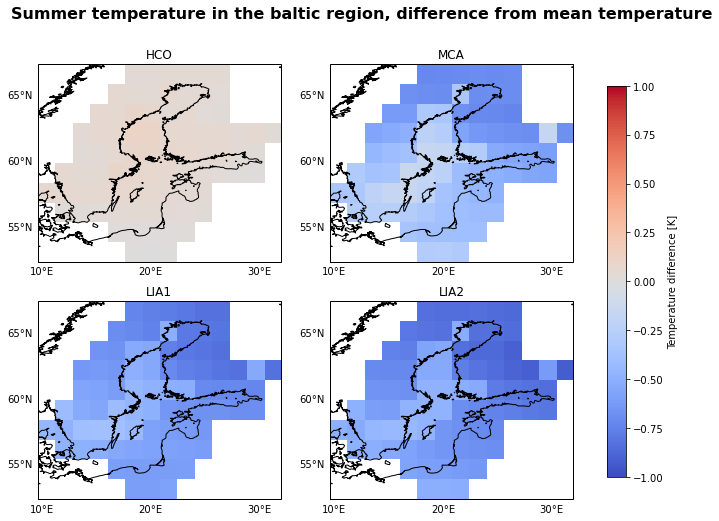

In [22]:
# colorbar range
vmin = -1
vmax = 1

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    hco_summer_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('HCO')

im2 = axs[0,1].imshow(
    mca_summer_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('MCA')

im3 = axs[1,0].imshow(
    lia1_summer_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('LIA1')

im4 = axs[1,1].imshow(
    lia2_summer_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('LIA2')

fig.suptitle('Summer temperature in the baltic region, difference from mean temperature', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, shrink=0.9, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Temperature difference [K]');

Fall difference to mean plot:

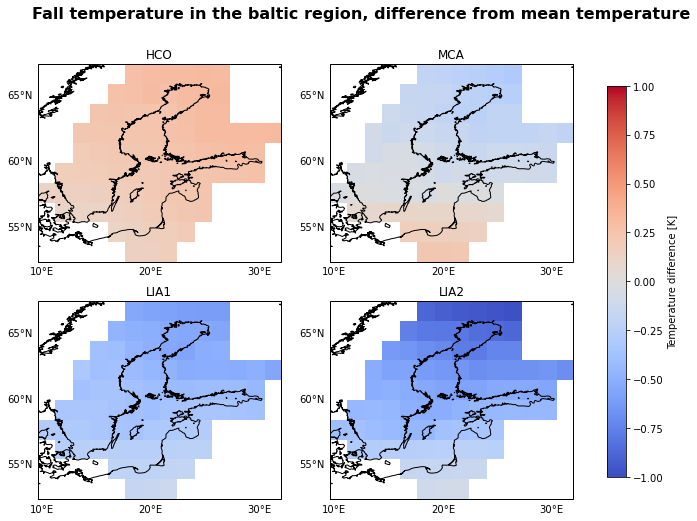

In [23]:
# colorbar range
vmin = -1
vmax = 1

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    hco_fall_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('HCO')

im2 = axs[0,1].imshow(
    mca_fall_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('MCA')

im3 = axs[1,0].imshow(
    lia1_fall_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('LIA1')

im4 = axs[1,1].imshow(
    lia2_fall_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('LIA2')

fig.suptitle('Fall temperature in the baltic region, difference from mean temperature', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, shrink=0.9, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Temperature difference [K]');

Winter difference to mean plot:

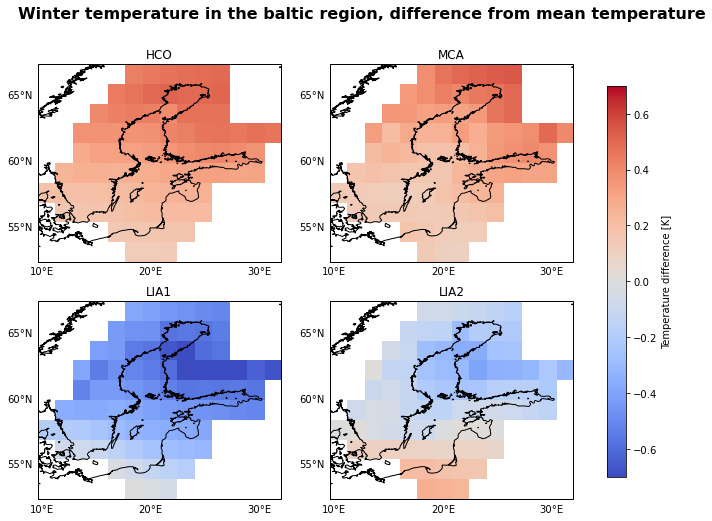

In [31]:
# colorbar range
vmin = -0.7
vmax = 0.7

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections

im1 = axs[0,0].imshow(
    hco_winter_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('HCO')

im2 = axs[0,1].imshow(
    mca_winter_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('MCA')

im3 = axs[1,0].imshow(
    lia1_winter_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('LIA1')

im4 = axs[1,1].imshow(
    lia2_winter_mean,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[9.6, 32, 52.4, 67.4],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('LIA2')

fig.suptitle('Winter temperature in the baltic region, difference from mean temperature', fontsize=16, fontweight='bold')

cbar = fig.colorbar(im4, shrink=0.9, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Temperature difference [K]');